# Example Notebook

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.nonparametric.kernel_regression import KernelReg

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from rdrobust import rdrobust

import doubleml as dml
from doubleml.rdd import RDFlex
from doubleml.rdd.datasets import make_simple_rdd_data

## Data

### Generate Data

In [2]:
np.random.seed(42)
data_dict = make_simple_rdd_data(n_obs=500)

cov_names = ['x' + str(i) for i in range(data_dict['X'].shape[1])]
df = pd.DataFrame(
    np.column_stack((data_dict['Y'], data_dict['D'], data_dict['score'], data_dict['X'])),
    columns=['y', 'd', 'score'] + cov_names,
)
df

,y,d,score,x0,x1,x2,x3
0,1.908268,0.0,-0.250920,-0.629734,0.083802,0.745892,0.464450
1,4.472041,1.0,0.901429,0.613122,0.317567,0.384553,0.698391
2,-1.422980,1.0,0.463988,-0.500664,-0.021150,-0.557581,0.975336
3,5.607752,0.0,0.197317,0.888119,-0.921146,0.411150,0.850497
4,1.801931,0.0,-0.687963,-0.638849,0.135890,0.830977,-0.932108
...,...,...,...,...,...,...,...
495,1.840549,0.0,-0.293296,-0.124677,-0.530053,0.409742,0.634256
496,1.789129,0.0,0.167312,0.092861,0.934071,-0.896663,0.009591
497,0.140040,0.0,-0.844531,0.436908,0.725281,-0.641489,0.600007
498,-2.899955,0.0,0.948790,0.105414,-0.206893,-0.736570,0.730592


In [3]:
fig = px.scatter(
    x=df['score'],
    y=df['y'],
    color=df['d'].astype(bool),
    labels={
        "x": "Score",   
        "y": "Outcome",
        "color": "Treatment"
    },
    title="Scatter Plot of Outcome vs. Score by Treatment Status"
)

fig.update_layout(
    xaxis_title="Score",
    yaxis_title="Outcome"
)
fig.show()

### Oracle Values and Comparisons

In [4]:
ite = data_dict['oracle_values']['Y1'] - data_dict['oracle_values']['Y0']
score = data_dict['score']

oracle_model = KernelReg(endog=ite, exog=score, reg_type='ll', var_type='c', ckertype='gaussian')

score_grid = np.linspace(-1, 1, 100)
oracle_effects, _ = oracle_model.fit(score_grid)


scatter = go.Scatter(
    x=score,
    y=ite,
    mode='markers',
    name='ITE',
    marker=dict(color='blue')
)
line = go.Scatter(
    x=score_grid,
    y=oracle_effects,
    mode='lines',
    name='Average Effect Estimate',
    line=dict(color='red')
)


fig = go.Figure(data=[scatter, line])
fig.update_layout(
    title='Locally Linear Kernel Regression of ITE on Score',
    xaxis_title='Score',
    yaxis_title='Effect',
    legend=dict(x=0.8, y=0.2)
)

fig.show()

## RDD with linear adjustment

In [5]:
rdrobust_linear = rdrobust(y=df['y'], x=df['score'], fuzzy=df['d'], covs=df[cov_names], c=0.0)
rdrobust_linear

Call: rdrobust
Number of Observations:                   500
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           241        259
Number of Unique Obs.            241        259
Number of Effective Obs.          68         93
Bandwidth Estimation           0.328      0.328
Bandwidth Bias                 0.607      0.607
rho (h/b)                       0.54       0.54

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        2.18    0.845     2.58   9.877e-03     [0.524, 3.836]
Robust                 -        -    2.572   1.011e-02     [0.579, 4.288]


## RDD with flexible adjustment

In [6]:
dml_data = dml.DoubleMLData(df, y_col='y', d_cols='d', x_cols=cov_names, s_col='score')

In [7]:
ml_g = LGBMRegressor(n_estimators=100, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=100, learning_rate=0.01, verbose=-1)

rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      n_folds=5,
                      n_rep=1)
rdflex_model.fit(n_iterations=2)

print(rdflex_model)

Method             Coef.     S.E.     t-stat       P>|t|           95% CI
-------------------------------------------------------------------------
Conventional      0.873     0.747     1.168    2.427e-01  [-0.592, 2.337]
Robust                 -        -     2.391    1.683e-02  [0.424, 4.280]


In [8]:
rdflex_model._rdd_obj[0]

Call: rdrobust
Number of Observations:                   500
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   Manual
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           241        259
Number of Unique Obs.            241        259
Number of Effective Obs.          87        107
Bandwidth Estimation           0.404      0.404
Bandwidth Bias                 0.404      0.404
rho (h/b)                        1.0        1.0

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.873    0.747    1.168   2.427e-01    [-0.592, 2.337]
Robust                 -        -    2.391   1.683e-02      [0.424, 4.28]


## Multiple Iterations

In [9]:
max_iterations = 10
n_rep = 10

ml_g = LGBMRegressor(n_estimators=100, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=100, learning_rate=0.01, verbose=-1)

rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      n_folds=5,
                      n_rep=n_rep)

all_coefs = np.full((max_iterations, n_rep), np.nan)
all_ses = np.full((max_iterations, n_rep), np.nan)

for i_iteration, n_iterations in enumerate(range(1, max_iterations+1)):
    rdflex_model.fit(n_iterations=n_iterations)
    all_coefs[i_iteration, :] = rdflex_model.all_coef[0,:]
    all_ses[i_iteration, :] = rdflex_model.all_se[0,:]


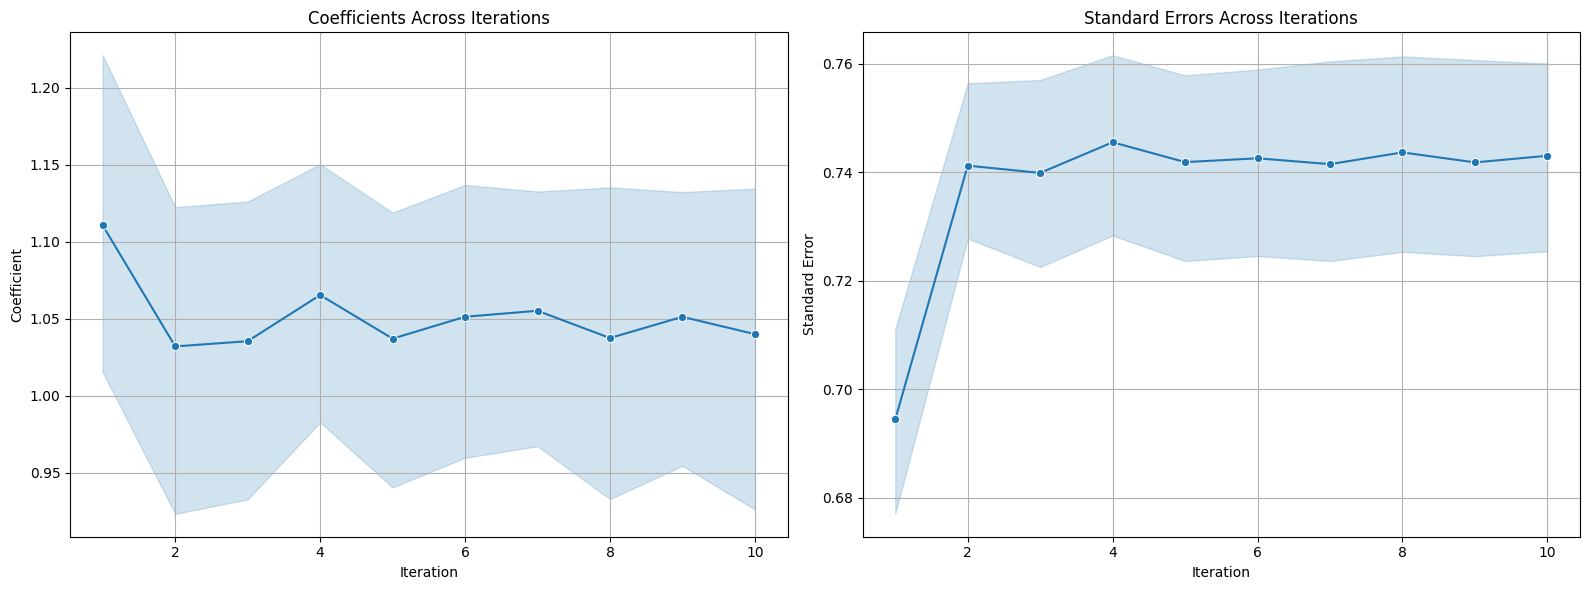

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


iterations = np.repeat(range(1, max_iterations + 1), n_rep)
repetitions = np.tile(range(1, n_rep + 1), max_iterations)
data = {'Iteration': iterations, 'Repetition': repetitions, 'Coefficient': all_coefs.flatten(), 'SE': all_ses.flatten()}

df = pd.DataFrame(data)

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for Coefficients
sns.lineplot(x='Iteration', y='Coefficient', data=df, marker='o', ax=axes[0])
axes[0].set_title('Coefficients Across Iterations')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Coefficient')
axes[0].grid(True)

# Plot for Standard Errors
sns.lineplot(x='Iteration', y='SE', data=df, marker='o', ax=axes[1])
axes[1].set_title('Standard Errors Across Iterations')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Standard Error')
axes[1].grid(True)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the plots
plt.show()